In [58]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from numba import njit
import math
import missingno as msno

In [ ]:
# to extract 3000 lines from training set
# df = pd.read_csv("../../training_set_VU_DM.csv")
# df2 = df.head(3000)
# df2.to_csv('small_data/3000_training_set_VU_DM.csv')

In [59]:
df = pd.read_csv("small_data/3000_training_set_VU_DM.csv")
df = df.drop(columns=["Unnamed: 0"])

search = df.loc[df['srch_id'] == 12]

first_half = df.iloc[:,:27]

orig_dest = df['orig_destination_distance']
data = df.iloc[:,:17]
# plt.hist()

print(set(df['site_id']))




{32, 5, 7, 9, 10, 12, 14, 15, 16, 18, 22, 23, 24, 25, 26, 31}


In [49]:
# print(first_half.iloc[:,:15])

In [47]:
 @njit
 def count_data(data):
    data = [float(value) for value in data]
    data = [int(value) for value in data if not math.isnan(value)]
    data = sorted(data)

    count = {}

    for value in data:
        count[value] = data.count(value)

    count = dict((k, v) for k, v in count.items() if v > 1)

    # count = dict(sorted(count.items(), key=lambda item: item[1]))

    labels = count.keys()
    counts = count.values()

    x = np.arange(len(labels))
    
    fig, ax = plt.subplots()
    ax.barh(x, counts)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Count')
    fig.tight_layout()
    plt.show()
    # fig.savefig("figures/random_nrs.pdf")

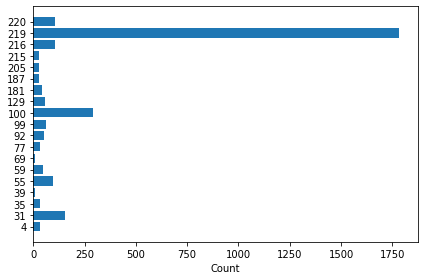

In [57]:
count_data(df["visitor_location_country_id"])

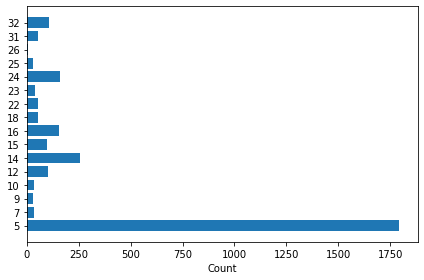

In [58]:
count_data(df["site_id"])

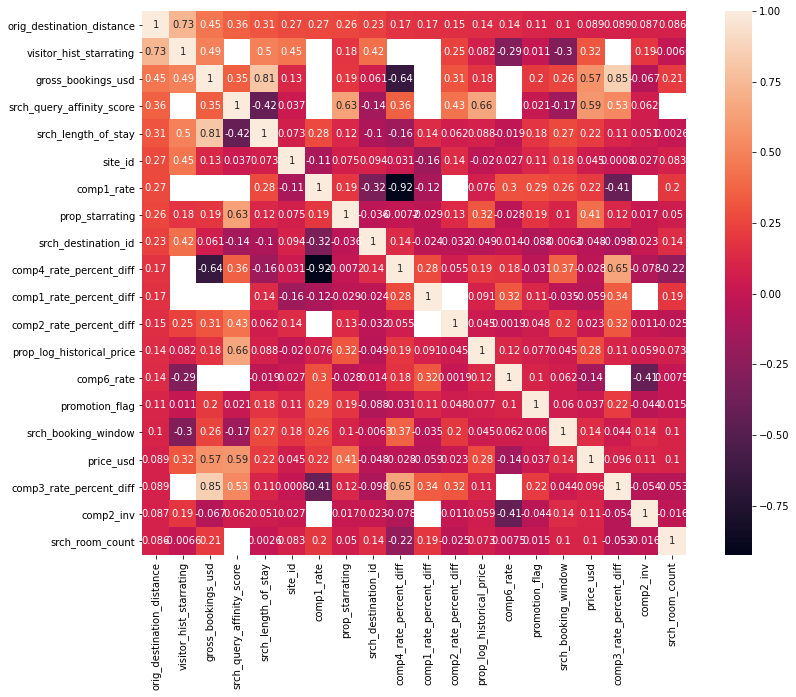

In [55]:
# Produce correlation heatmap, to see which columns correlate with the age.
def make_corrmap(data, vactor):
    corrmat = data.corr()
    k = 20 #Number of variables for heat map with largest correlation.
    cols = corrmat.nlargest(k, vactor)[vactor].index
    f, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(data[cols].corr(), vmax=1, square=True, annot=True)

# Fare has highest correlation with Pclass. 
# Use the avergae Fare of people with the same Pclasss to fill in missing value.
make_corrmap(df, 'orig_destination_distance')

In [70]:
"""
orig_destination_dist
Kijken of hetzelfde hotel bij iemand uit hetzelfde land voor komt en dan deze afstand gebruiken
en als meerdere uit zelfde land dat hotel hebben dan gewoon de average.
"""

orig_dest2 = copy.deepcopy(orig_dest)

for i in tqdm(range(len(orig_dest))):
    # print(orig_dest[i])
    if not np.isnan(orig_dest[i]):
        continue

    row = df.iloc[i]
    country = row['visitor_location_country_id']
    hotel = row['prop_country_id']
    # print(country, hotel)

    other = df.loc[df['visitor_location_country_id'] == country]
    # print(other)
    hotel_other = other.loc[other['prop_country_id'] == hotel]
    # print(hotel_other)

    other_way = df.loc[df['visitor_location_country_id'] == hotel]
    other_way_hotel = other_way.loc[other_way['prop_country_id'] == country]
    
    # if len(other_way_hotel) > 0: 
    #     print("\nhoi")
    #     print(country, hotel)
        # print(len(other_way_hotel))
        # print())
        # break

    dist = hotel_other['orig_destination_distance']
    # print(dist)
    
    # if country and hotel are the same set distance to 0
    if country == hotel and np.isnan(np.mean(dist)):
        orig_dest2[i] = 0
    # if people booked from hotel country to your country then distance is same
    elif len(other_way_hotel) > 0 and np.isnan(np.mean(dist)):
        orig_dest2[i] = np.mean(np.mean(other_way_hotel['orig_destination_distance']))
    else:
        orig_dest2[i] = np.mean(dist)
    # search = df.loc[df['srch_id'] == 12]
    # break

100%|██████████| 3000/3000 [00:02<00:00, 1261.14it/s]


In [71]:
# print(orig_dest)
# print(orig_dest2)
print(orig_dest.isna().sum())
print(orig_dest2.isna().sum())

print(count, len(orig_dest))
print(np.mean(orig_dest))

928
402
928 3000
1282.137224903475


In [82]:
"""
Hey,een oplossing voor de overige van orig_destination_distance. De mean afstand van iedereen naar het land van het hotel?

en dan dit ook andersom?
"""

orig_dest3 = copy.deepcopy(orig_dest2)

for i in tqdm(range(len(orig_dest3))):
    # print(orig_dest3[i])
    if not np.isnan(orig_dest3[i]):
        continue
    
    row = df.iloc[i]
    country = row['visitor_location_country_id']
    hotel = row['prop_country_id']

    # get everyone who goes to the same country
    destination = df.loc[df['prop_country_id'] == hotel]
    mean_dist = np.mean(destination['orig_destination_distance'])


    if np.isnan(mean_dist):
        country = row['prop_country_id']
        
        # get everyone who comes from the same country
        origin = df.loc[df['visitor_location_country_id'] == hotel]

        # print("\n", country, hotel, np.mean(destination['orig_destination_distance']))
        mean_dist = np.mean(origin['orig_destination_distance'])
    
    orig_dest3[i] = mean_dist


100%|██████████| 3000/3000 [00:00<00:00, 7421.89it/s]


In [83]:
print(orig_dest3.isna().sum())

219


In [87]:
same = set()

for i in tqdm(range(len(orig_dest3))):
    if not np.isnan(orig_dest3[i]):
        continue

    row = df.iloc[i]
    country = row['visitor_location_country_id']
    hotel = row['prop_country_id']

    destination = df.loc[df['prop_country_id'] == hotel]

    if (country, hotel) not in same:
        same.add((country, hotel))
        print("\n", country, hotel)


100%|██████████| 3000/3000 [00:00<00:00, 14622.40it/s]
 216 15 nan

 220 98 nan

 77 30 nan

 216 98 nan

 205 15 nan

 181 55 nan

 220 221 nan

 39 202 nan

 99 132 nan



In [131]:
# destination = df.loc[df['prop_country_id'] == 15]
# print(destination['orig_destination_distance'])

countries = [15, 220, 98, 77, 30, 216, 98, 205, 181, 55, 221, 39, 202, 39, 99, 132]

for number in countries:
    not_nan = False

    # get everyone that comes from same country
    origin = df.loc[df['visitor_location_country_id'] == number]
    origin = [0]

    if len(origin) > 0:
        print(number)
        # check if any distance is not nan
        # for i in range(len(origin)):
        #     row = origin.iloc[i]

        #     dist = row['orig_destination_distance']

        #     if not np.isnan(dist):
        #         print("hoi dit is uit het zelfde land")
        #         print(dist, number, row['visitor_location_country_id'], row['prop_country_id'])
        #         not_nan = True
        
        # so if distance from country all nan, then check destination
        if not not_nan:
            print("hoi")
            # get everyone who goes to country
            destination = df.loc[df['prop_country_id'] == number]
            if len(destination) > 0:
                print("hoi2")
                print(destination['orig_destination_distance'])
                for i in range(len(destination)):
                    row = destination.iloc[i]

                    dist = row['orig_destination_distance']
                    if not np.isnan(dist):
                        print("hoi dit is naar het land 216 toe")
                        print(dist, number, row['visitor_location_country_id'])
                        not_nan = True
    break

15
hoi
hoi2
318    NaN
319    NaN
320    NaN
321    NaN
322    NaN
323    NaN
324    NaN
325    NaN
326    NaN
327    NaN
328    NaN
329    NaN
330    NaN
331    NaN
332    NaN
333    NaN
334    NaN
335    NaN
336    NaN
337    NaN
338    NaN
339    NaN
340    NaN
341    NaN
342    NaN
343    NaN
993    NaN
994    NaN
995    NaN
996    NaN
997    NaN
998    NaN
999    NaN
1000   NaN
1001   NaN
1002   NaN
1003   NaN
1004   NaN
1005   NaN
1006   NaN
1007   NaN
1008   NaN
1009   NaN
1010   NaN
1011   NaN
1012   NaN
1013   NaN
1014   NaN
1015   NaN
1016   NaN
1017   NaN
1018   NaN
1019   NaN
1020   NaN
1021   NaN
1022   NaN
Name: orig_destination_distance, dtype: float64


In [146]:
countries1 = set(df['visitor_location_country_id'])
countries2 = set(df['prop_country_id'])

countries = countries1.union(countries2)
print("total countries", len(countries))

# countries = [15, 220, 98, 77, 30, 216, 98, 205, 181, 55, 221, 39, 202, 39, 99, 132, 216, 219]

for number in countries:
    origin = df.loc[df['visitor_location_country_id'] == number]
    destination = df.loc[df['prop_country_id'] == number]

    dist_o = origin['orig_destination_distance']
    dist_d = destination['orig_destination_distance']

    if dist_o.isna().sum() == len(origin) and dist_d.isna().sum() == len(destination):
        print(number)

total countries 32
4
132
15
30
35
39
181
55
187
69
202
77
205
92
221
98


In [142]:
countries = [15, 220, 98, 77, 30, 205, 181, 55, 221, 39, 202, 99, 132, 216, 219]

for number in countries:
    origin = df.loc[df['visitor_location_country_id'] == number]
    destination = df.loc[df['prop_country_id'] == number]

    dist_o = origin['orig_destination_distance']
    dist_d = destination['orig_destination_distance']

    if dist_o.isna().sum() == len(origin) and dist_d.isna().sum() == len(destination):
        print(number)

15
98
77
30
205
181
55
221
39
202
132


In [162]:
all_countries = set()
countries_dist = set()

df2 = pd.read_csv("../../training_set_VU_DM.csv")

for i in tqdm(range(len(df2))):
    row = df2.iloc[i]

    orig = row['visitor_location_country_id']
    dest = row['prop_country_id']

    all_countries.add(orig)
    all_countries.add(dest)

    dist = row['orig_destination_distance']

    if not np.isnan(dist):
        countries_dist.add(orig)
        countries_dist.add(dest)

print("\nleng all", len(all_countries))
print("leng dist", len(countries_dist))

for number in all_countries:
    if number not in countries_dist:
        print(number)
    

100%|██████████| 4958347/4958347 [35:11<00:00, 2348.11it/s]
leng all 222
leng dist 165
3
5
6
12
28
29
36
51
52
54
58
62
64
66
67
78
84
85
89
94
95
101
105
107
108
110
114
115
116
118
121
130
133
135
139
142
148
150
165
166
168
170
174
176
183
188
190
191
193
198
199
209
210
218
227
228
231



In [164]:
distance = df2['orig_destination_distance']
np.mean(distance)

1301.234405997199

In [157]:

orig = df.loc[df['visitor_location_country_id'] == 15]
dest = df.loc[df['prop_country_id'] == 15]

print(orig['orig_destination_distance'])
# print(dest['orig_destination_distance'])

Series([], Name: orig_destination_distance, dtype: float64)


In [159]:
whole_df = pd.read_csv("../../training_set_VU_DM.csv")
df_new = whole_df.head(50000)

df_new.to_csv('small_data/50000_training_set_VU_DM.csv')

In [310]:
def orig_dest_distance_pandas_backup(visitor_country_id, prop_country_id, orig_destination_distance, i):
    orig = visitor_country_id[i]
    dest = prop_country_id[i]

    # check if someone has the exact same but with a distance
    others_pd = df.loc[df['visitor_location_country_id'] == orig]
    others = others_pd.loc[others_pd['prop_country_id'] == dest]

    if len(others) > 0 and others['orig_destination_distance'].isna().sum() < len(others):
        return np.mean(others['orig_destination_distance'])

    # only from same country
    others = df.loc[df['visitor_location_country_id'] == orig]

    if len(others) > 0 and others['orig_destination_distance'].isna().sum() < len(others):
        return np.mean(others['orig_destination_distance'])

    # only to same country
    others = df.loc[df['prop_country_id'] == dest]

    if len(others) > 0 and others['orig_destination_distance'].isna().sum() < len(others):
        return np.mean(others['orig_destination_distance'])
    
    return 1301

In [344]:
def orig_dest_distance(visitor_country_id, prop_country_id, orig_destination_distance, i):
    orig = visitor_country_id[i]
    dest = prop_country_id[i]

    # check if someone has the exact same but with a distance
    home = np.where(visitor_country_id == orig)
    destination = np.where(prop_country_id == dest)

    others_index = np.intersect1d(home, destination)
    others = np.take(orig_destination_distance, others_index)
    
    nans_np = np.count_nonzero(np.isnan(others))

    if len(others) > 0 and nans_np < len(others):
        return np.nanmean(others)

    # only from same country
    others = np.where(visitor_country_id == orig)
    others = np.take(orig_destination_distance, others)

    nans_np = np.count_nonzero(np.isnan(others))

    if len(others) > 0 and nans_np < len(others):
        return np.nanmean(others)

    # only to same country
    others = np.where(prop_country_id == dest)
    others = np.take(orig_destination_distance, others)

    nans_np = np.count_nonzero(np.isnan(others))
    if len(others) > 0 and nans_np < len(others):
        return np.nanmean(others)
    
    return 1301

In [345]:
def missing_distance(visitor_country_id, prop_country_id, orig_destination_distance):
    for i in tqdm(range(len(orig_destination_distance))):

        if np.isnan(orig_destination_distance[i]):
            result = orig_dest_distance(visitor_country_id, prop_country_id, orig_destination_distance, i)
            orig_destination_distance[i] = result

    return orig_destination_distance

In [346]:
df = pd.read_csv("small_data/50000_training_set_VU_DM.csv")

visitor_country_id = df['visitor_location_country_id'].to_numpy()
prop_country_id = df['prop_country_id'].to_numpy()
orig_destination_distance = df['orig_destination_distance'].to_numpy()

df['orig_destination_distance'] = missing_distance(visitor_country_id, prop_country_id, orig_destination_distance)

if df['orig_destination_distance'].isna().sum() != 0:
    print("distance still has nans!!!!")

100%|██████████| 50000/50000 [00:23<00:00, 2105.16it/s]
